# MAD Straddle

Coding an article from moontower.ai that explores approximating the price of a straddle and its relation to the mean absolute deviation. The main article is linked below, as well as a useful thread from @10kdiver on Twitter.

References:
[*Moontower*](https://resources.moontower.ai/the-mad-straddle)
[*10-K Diver Thread*](https://x.com/10kdiver/status/1393636244731482112)

Mean Absolute deviation is similar to standard deviation, except it uses absolute value instead of squaring to make sure positive and negative deviations from a mean don't cancel. Also note that median absolute deviation is referred to as MAD.

$$\text{MAD} = \frac{1}{n} \sum_{i=1}^{n} |x_i - \bar{x}|$$
and
$$SD = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2}$$
Just divide by n-1 instead for the sample version.

For a gaussian distribution, $MAD = \sqrt{\frac{2}{\pi}} SD$ and $\sqrt{\frac{2}{\pi}} \approx 0.8$

So: $MAD = 0.8 SD$ and $SD = 1.25MAD$

Let's check this:

In [237]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

In [238]:
# Create a MAD function
def mad(data, sample=False):
    if not sample:
        return np.mean(np.abs(data - data.mean(0)))
    else:
        return np.sum(np.abs(data - data.mean(0))) / (len(data) - 1)

norm_sample = np.random.normal(size=10000)  # Get a sample from a standard normal distribution

print(mad(norm_sample))
print(norm_sample.std())

0.8124648173863903
1.0171795974284066


What if the distribution isn't normal? What can the ratio of SD to MAD tell us if it differs from 1.25?

Because of the squaring, SD gives more weight to outliers, so if the distribution is fat-tailed, we have more outliers and the ratio will be larger.  

For example, what about stock returns:

In [239]:
def get_returns(ticker='spy', start_date='2018-1-2', end_date='2019-12-31'):
    data_hold=yf.Ticker(ticker)
    return_df=data_hold.history(start=start_date,  end=end_date)
    return_df['Daily_Ret'] = return_df.Close.pct_change()  # Calculate daily returns
    return return_df

# plt.hist(spy_df.Daily_Ret, bins=40);
spy_df = get_returns('spy')
spy_df.Daily_Ret.std() / mad(spy_df.Daily_Ret, sample=True) 

1.4502263660377899

Here's a more extreme example: a bunch of zeros and one 100

In [240]:
fat_tail = np.zeros(10)
fat_tail[0] = 100

fat_tail.std(ddof=1) / mad(fat_tail, sample=True)

1.5811388300841895

Here's how the ratio increases as the number of zeros increase:

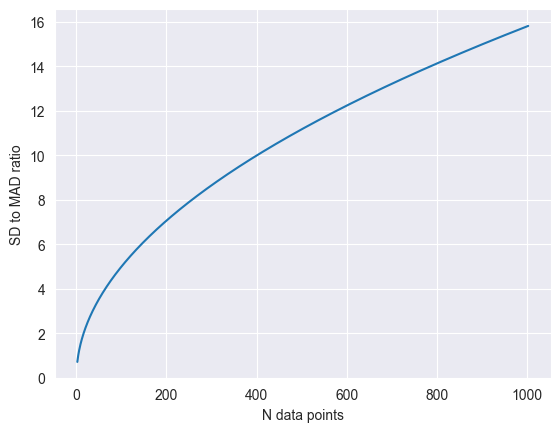

In [241]:
n = 1000
ratio = np.zeros([2,n])
for i in range(2,n+2):
    fat_tail = np.zeros(i)
    ratio[0,i-2] = i + 1
    fat_tail[0] = 100
    ratio[1,i-2] = fat_tail.std(ddof=1) / mad(fat_tail, sample=True)

plt.xlabel('N data points')
plt.ylabel('SD to MAD ratio')
plt.plot(ratio[0], ratio[1]);

How does this relate to a straddle? First let's look at an approximation of an ATF (at the forward) straddle.

First off, a long (short) straddle is buying (selling) a call and put at the same exercise price:  

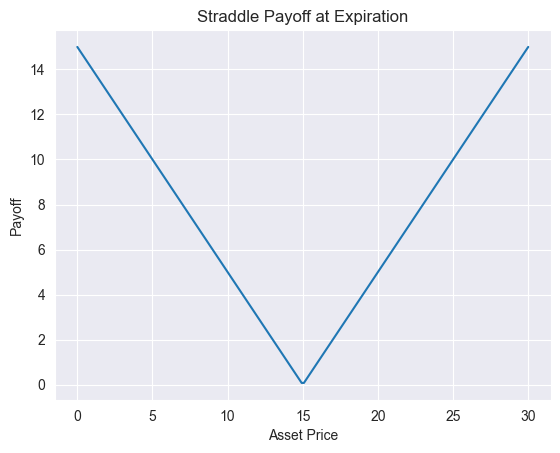

In [242]:
x = np.linspace(0,30,200)
y = np.maximum(x-15,0) + np.maximum(15-x,0)  # Intrinsic value of a call and put at a strike of 15
plt.title('Straddle Payoff at Expiration')
plt.xlabel('Asset Price')
plt.ylabel('Payoff')
plt.plot(x,y);

Using Black-Scholes, an ATF Call has $d_1 = 0.5\sigma\sqrt{T}$ and $d_1 = -0.5\sigma\sqrt{T}$. Let's confirm this result.

In [243]:
def black_scholes(sigma, K, r, S0, T, is_call=True, d=0):
    d1 = (math.log(S0 / K) + (r - d + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if is_call:
        price = S0 * norm.cdf(d1) * math.exp(-d * T) - K * math.exp(-r * T) * norm.cdf(d2)
        return float(price), float(d1), float(d2)
    else:
        price =  K * math.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1) * math.exp(-d * T)
        return float(price), float(d1), float(d2)

In [244]:
# Stock parameters
sigma = 0.2
S0 = 100
r = 0.05
T = 1
K = S0 * np.exp(r * T)

With these parameters, we expect $d_1 = 0.5\sigma\sqrt{T} = 0.5 \times 0.2 \times \sqrt{1} = 0.1$ and $d_2 = -0.1$.

In [245]:
price, d1, d2 = black_scholes(sigma, K, r, S0, T)
print(f'd1 = {round(d1,3)}, d2 = {round(d2,3)}')

d1 = 0.1, d2 = -0.1


Recall the price of a call is calculated with:

$$C = N(d_1)S_0 - N(d_2) Ke^{-rT}$$

Because the strike is ATF, discounting it means:

$$C_{ATF} = N(d_1)S_0 - N(d_2)S_0$$

This means that the at the money call is equal to the area under the curve between d1 and d2 times the stock price!

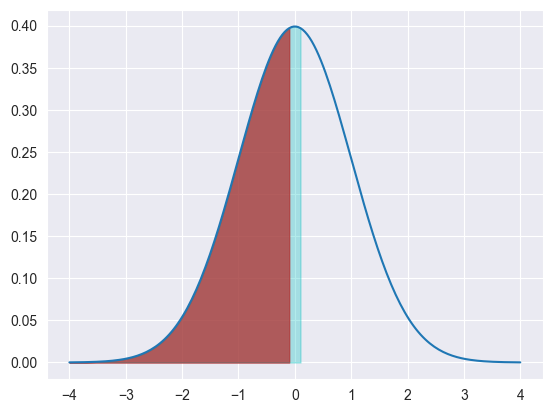

In [246]:
x = np.linspace(-4,4,200)
plt.plot(x,norm.pdf(x))

x_d2 = np.linspace(-4,d2,200)
plt.fill_between(x_d2,norm.pdf(x_d2),color='r', alpha=0.8)

x_d1 = np.linspace(-4,d1,200)
plt.fill_between(x_d1,norm.pdf(x_d1),color='c', alpha=0.3);

N(d2) is the red, and N(d1) is the blue that continues under the red. Notice this is very close to a rectangle. The area of this rectangle is our approximation of the ATF call! The error will be the corners at the top of the rectangle and tell us that the approximation will slightly overestimate the call's value.

The height is approximately 0.4, since the standard normal pdf reduces to $\frac{1}{\sqrt{2\pi}}$ when x is 0. The base is $\sigma\sqrt{T}$. So the area is approximately $0.4\sigma\sqrt{T}$. For the value of the call, multiply this by the stock price and get: $0.4\sigma\sqrt{T}S_0$

For the example that becomes: $0.4 \times 0.2 \times \sqrt{1} \times 100 = 8$

Black-Scholes gave us:

In [247]:
price

7.96556745540579

Very close, and the approximation overestimated as expected. This is just for the call, what about the put? This is where put-call parity comes in. Recall:

$$C + Ke^{-rT} = P + S_0$$

Once again, the discounted ATF strike becomes $S_0$ and the call and put are equal ATF. So the straddle is just double the call approximation and it becomes:
$$0.8 \times \sigma \times \sqrt{T} \times S_0$$

In [248]:
call_price, d1, d2 = black_scholes(sigma, K, r, S0, T)
put_price, d1, d2 = black_scholes(sigma, K, r, S0, T, is_call=False)
straddle_bs = put_price + call_price
straddle_approx = 0.8 * sigma * np.sqrt(T) * S0

print(f'Black-Scholes straddle: {round(straddle_bs,4)}, straddle_approx: {round(straddle_approx,4)}')

Black-Scholes straddle: 15.9311, straddle_approx: 16.0


Where does MAD come into play?

Recall that $MAD = 0.8 SD$. That is the same as the approximation! The approximation just also adjusts for the time and price of the stock. The main part is 0.8 times the volatility which is a standard deviation. So, the price of a straddle is the MAD adjusted for time and stock price.

What about the error and what might make the approximation worse?

The wider the rectangle is, the more error there is. The width is dependent on the time and volatility. Assuming we are looking at a set expiration, the error will be larger for larger volatilities. 

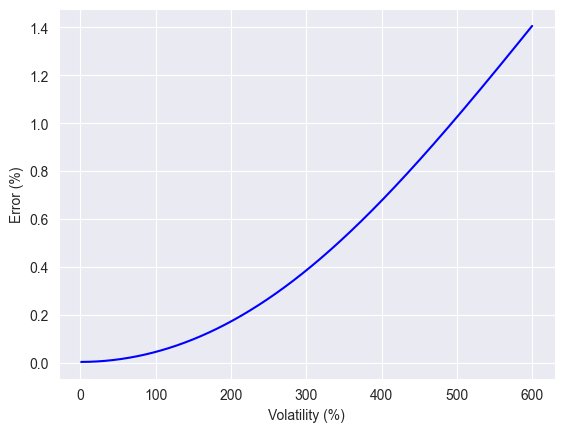

In [249]:
res = 3000
vol_range = np.linspace(0.01,6, res)
err_arr = np.zeros([2,res])
for i in range(res):
    err_arr[0,i] = vol_range[i] * 100
    
    call_price, d1, d2 = black_scholes(vol_range[i], K, r, S0, T)
    put_price, d1, d2 = black_scholes(vol_range[i], K, r, S0, T, is_call=False)
    straddle_bs = put_price + call_price
    straddle_approx = 0.8 * vol_range[i] * np.sqrt(T) * S0
    
    error = straddle_approx / straddle_bs -1
    err_arr[1,i] = error

plt.xlabel('Volatility (%)')
plt.ylabel('Error (%)')
plt.plot(err_arr[0], err_arr[1], 'b');

For vol less than 100%, we have a pretty good approximation. At 100% volatility the error is around 4.5%.